<a href="https://colab.research.google.com/github/Ananyajainhdjsj/Ananyajainhdjsj/blob/main/trained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
!pip install -q imbalanced-learn scikit-learn pandas numpy matplotlib seaborn openpyxl


In [19]:
from google.colab import files
import pandas as pd
import io

uploaded = files.upload()
df = pd.read_excel(io.BytesIO(uploaded['dataset.xlsx']))
df.head()


Saving dataset.xlsx to dataset.xlsx


,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nationality,Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 2nd sem (credited) 0 to 19,Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,8,5,2,1,1,1,13,10,6,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,6,1,11,1,1,1,1,3,4,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,5,1,1,1,22,27,10,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,8,2,15,1,1,1,23,27,6,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,1,12,1,3,0,1,1,22,28,10,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [20]:
# Drop columns that are unnamed or constant
df.drop(columns=[col for col in df.columns if 'Unnamed' in col or df[col].nunique() <= 1], inplace=True)

# Fill missing numeric values with median
df.fillna(df.median(numeric_only=True), inplace=True)

# Check for nulls
df.isnull().sum()


,0
Marital status,0
Application mode,0
Application order,0
Course,0
Daytime/evening attendance,0
Previous qualification,0
Nationality,0
Mother's qualification,0
Father's qualification,0
Mother's occupation,0


In [21]:
df['performance_ratio_1st'] = df['Curricular units 1st sem (approved)'] / df['Curricular units 1st sem (enrolled)'].replace(0, 1)
df['performance_ratio_2nd'] = df['Curricular units 2nd sem (approved)'] / df['Curricular units 2nd sem (enrolled)'].replace(0, 1)
df['economic_index'] = (df['Unemployment rate'] + df['Inflation rate']) / df['GDP']
df.replace([float('inf'), -float('inf')], 0, inplace=True)
df.fillna(0, inplace=True)


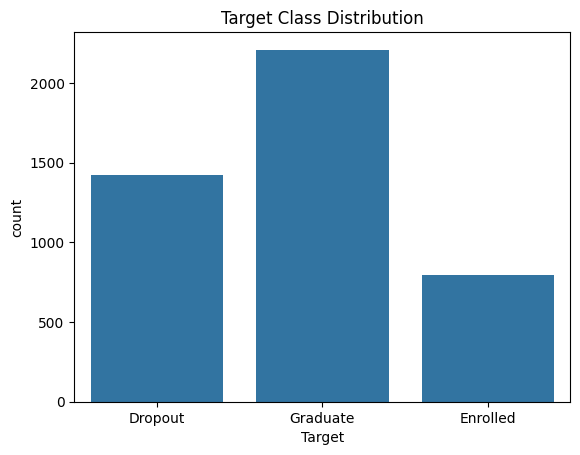

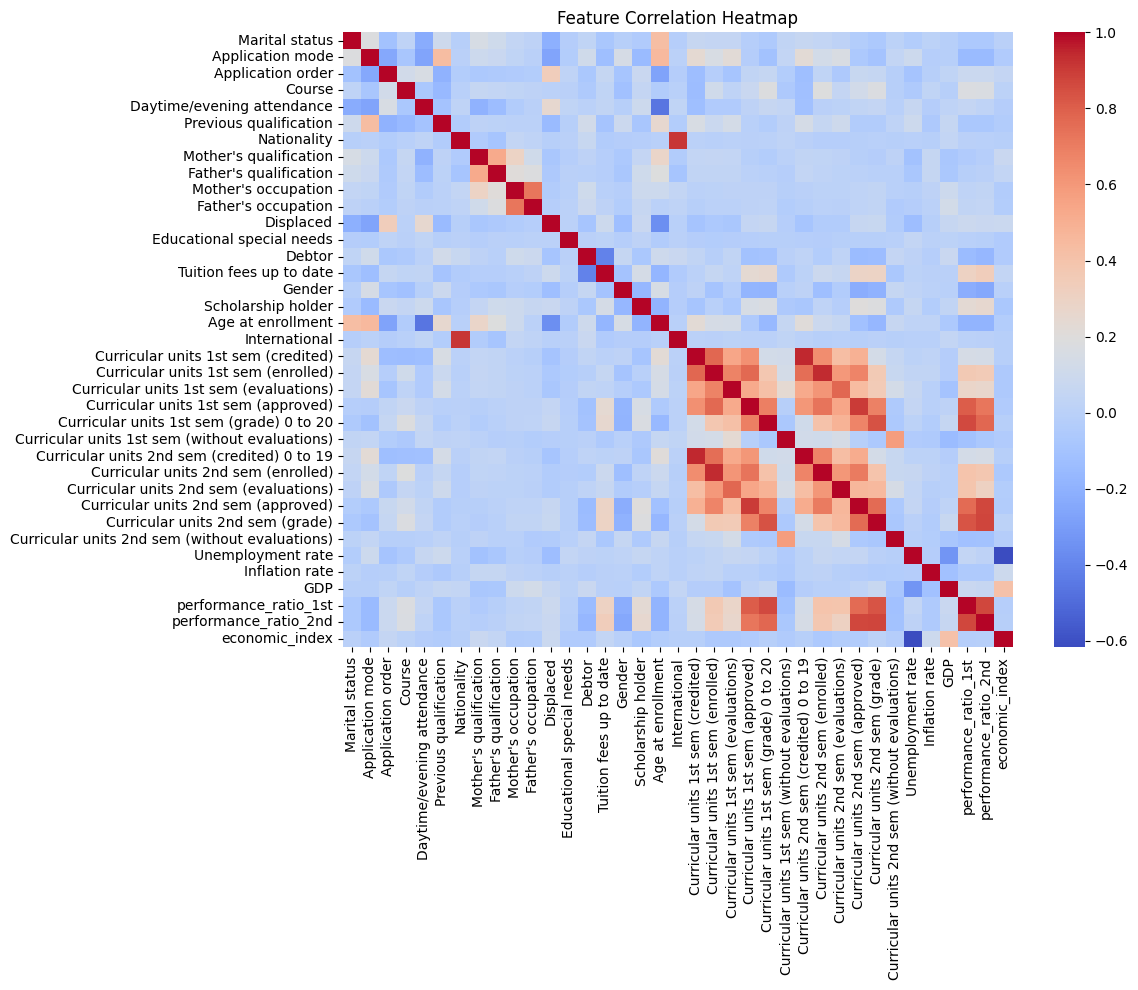

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Class distribution
sns.countplot(x='Target', data=df)
plt.title('Target Class Distribution')
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(numeric_only=True), cmap='coolwarm', annot=False)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Features and target
X = df.drop('Target', axis=1)
y = df['Target']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)


In [24]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from imblearn.pipeline import Pipeline as ImbPipeline

models = {
    'Logistic Regression': (LogisticRegression(max_iter=1000), {
        'classifier__C': [0.1, 1],
        'classifier__class_weight': ['balanced', None]
    }),
    'Random Forest': (RandomForestClassifier(), {
        'classifier__n_estimators': [100],
        'classifier__class_weight': ['balanced']
    }),
    'Gradient Boosting': (GradientBoostingClassifier(), {
        'classifier__n_estimators': [100],
        'classifier__learning_rate': [0.1]
    })
}

best_models = {}
for name, (clf, params) in models.items():
    print(f"\n🔹 Training {name}")
    pipe = ImbPipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('classifier', clf)
    ])
    gs = GridSearchCV(pipe, params, cv=StratifiedKFold(5), scoring='f1_weighted', n_jobs=-1)
    gs.fit(X_train, y_train)
    y_pred = gs.predict(X_test)
    print(classification_report(y_test, y_pred))
    best_models[name] = (gs.best_estimator_, accuracy_score(y_test, y_pred))



🔹 Training Logistic Regression
              precision    recall  f1-score   support

     Dropout       0.82      0.68      0.75       284
    Enrolled       0.41      0.62      0.50       159
    Graduate       0.86      0.80      0.83       442

    accuracy                           0.73       885
   macro avg       0.70      0.70      0.69       885
weighted avg       0.77      0.73      0.74       885


🔹 Training Random Forest
              precision    recall  f1-score   support

     Dropout       0.82      0.74      0.77       284
    Enrolled       0.49      0.51      0.50       159
    Graduate       0.83      0.87      0.85       442

    accuracy                           0.76       885
   macro avg       0.71      0.71      0.71       885
weighted avg       0.77      0.76      0.76       885


🔹 Training Gradient Boosting
              precision    recall  f1-score   support

     Dropout       0.81      0.75      0.78       284
    Enrolled       0.47      0.46      0.

In [25]:
import joblib
from google.colab import files

# Save the best-performing model
best_model_name = max(best_models, key=lambda k: best_models[k][1])
best_model = best_models[best_model_name][0]

joblib.dump(best_model, 'student_dropout_best_model.pkl')
files.download('student_dropout_best_model.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

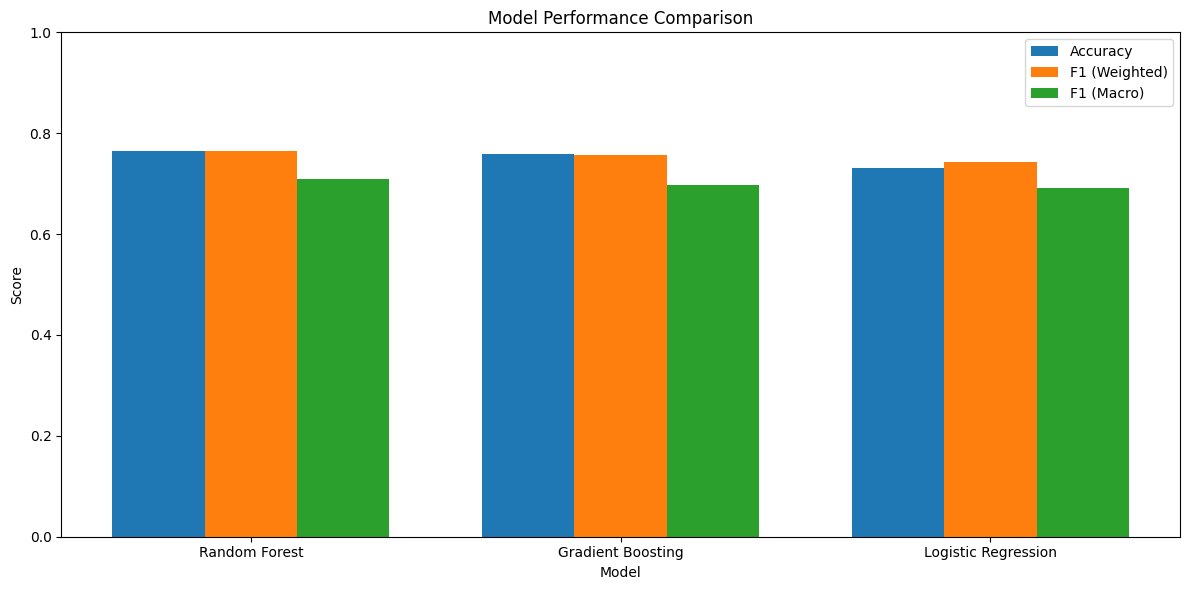

In [26]:
# Build comparison table
import pandas as pd
import numpy as np

comparison = []
for name, (model, acc) in best_models.items():
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    comparison.append({
        'Model': name,
        'Accuracy': acc,
        'F1 (Weighted)': report['weighted avg']['f1-score'],
        'F1 (Macro)': report['macro avg']['f1-score']
    })

comparison_df = pd.DataFrame(comparison).sort_values('Accuracy', ascending=False).reset_index(drop=True)
comparison_df
# Plot comparison chart
import matplotlib.pyplot as plt

x = np.arange(len(comparison_df))
width = 0.25

plt.figure(figsize=(12, 6))
plt.bar(x - width, comparison_df['Accuracy'], width, label='Accuracy')
plt.bar(x, comparison_df['F1 (Weighted)'], width, label='F1 (Weighted)')
plt.bar(x + width, comparison_df['F1 (Macro)'], width, label='F1 (Macro)')

plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, comparison_df['Model'])
plt.legend()
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


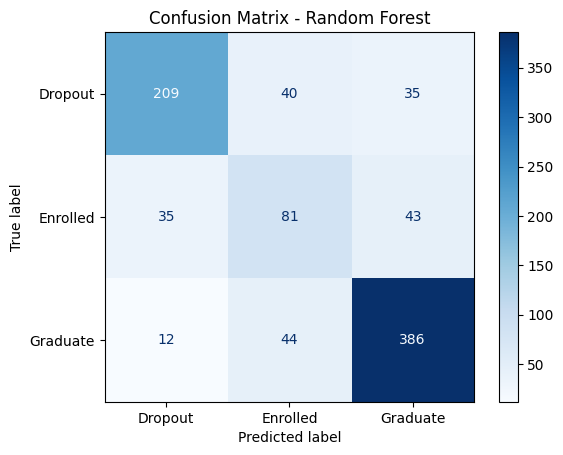

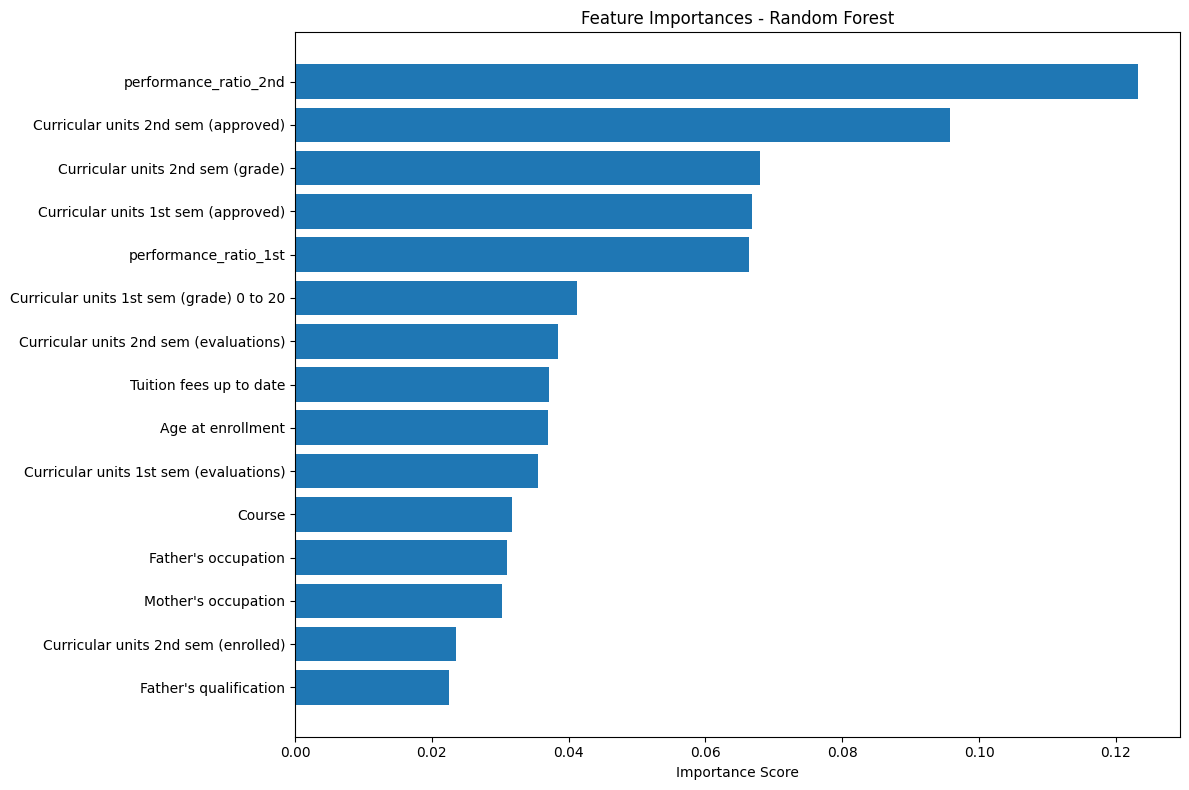

In [27]:
from sklearn.metrics import ConfusionMatrixDisplay

y_pred_best = best_model.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_best, cmap="Blues")
plt.title(f'Confusion Matrix - {best_model_name}')
plt.show()
if hasattr(best_model.named_steps['classifier'], 'feature_importances_'):
    importances = best_model.named_steps['classifier'].feature_importances_
    features = X.columns
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(12, 8))
    plt.title(f"Feature Importances - {best_model_name}")
    plt.barh(range(15), importances[indices[:15]][::-1])
    plt.yticks(range(15), [features[i] for i in indices[:15]][::-1])
    plt.xlabel("Importance Score")
    plt.tight_layout()
    plt.show()
else:
    print("Feature importances not available for this model.")


In [28]:
from IPython.display import Markdown

Markdown(f"""
### 🎯 Final Summary

- **Best Performing Model:** `{best_model_name}`
- **Accuracy:** {best_models[best_model_name][1]:.4f}
- **Class Imbalance** was handled using **SMOTE**
- **Feature Engineering** added:
  - `performance_ratio_1st`, `performance_ratio_2nd`
  - `economic_index`
- **Hyperparameter tuning** via GridSearchCV improved results
- Confusion matrix and F1 scores validate the model’s balance and fairness.

This model can now be used to **predict student dropout risk** and support proactive academic interventions.
""")



### 🎯 Final Summary

- **Best Performing Model:** `Random Forest`
- **Accuracy:** 0.7638
- **Class Imbalance** was handled using **SMOTE**
- **Feature Engineering** added:
  - `performance_ratio_1st`, `performance_ratio_2nd`
  - `economic_index`
- **Hyperparameter tuning** via GridSearchCV improved results
- Confusion matrix and F1 scores validate the model’s balance and fairness.

This model can now be used to **predict student dropout risk** and support proactive academic interventions.
